In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    f1_score, 
    classification_report, 
    ConfusionMatrixDisplay, 
    mean_squared_error, 
    make_scorer, mean_squared_error,  
    mean_absolute_error, r2_score
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

In [52]:
df_train = pd.read_csv('combined_train_with_labels.csv.gz')

df_test = pd.read_csv('combined_test_with_labels.csv.gz')

In [53]:
df_train['energy_label']

0           582.364295
1           250.159995
2          1212.323954
3           240.878110
4           285.124189
              ...     
1039995     210.834626
1039996     380.170340
1039997     370.109563
1039998      98.258524
1039999     281.715768
Name: energy_label, Length: 1040000, dtype: float64

In [54]:
type(df_train['psd_label_low_avse'][0])

numpy.bool

In [55]:
df_train_reg = df_train.copy()
df_test_reg = df_test.copy()


In [56]:
df_train_reg = df_train_reg.rename(columns={"SC": "SCA"})


In [57]:
print(df_train_reg.columns)
print(df_test_reg.columns)

Index(['id', 'energy_label', 'psd_label_low_avse', 'psd_label_high_avse',
       'psd_label_dcr', 'psd_label_lq', 'tp0', 'ED', 'HWP', 'LQ80', 'PPR',
       'SCA', 'current_skewness', 'spectral_centroid_power',
       'tail_charge_diff', 'current_kurtosis', 'total_power',
       'time_to_main_peak', 'time_to_peak', 'late_over_early', 'tdrift99',
       'tfr', 'peak_count', 'gbn', 'bpr', 'AvsE', 'GradAreaRatio',
       'GradWidthMain', 'HFER'],
      dtype='object')
Index(['id', 'energy_label', 'psd_label_low_avse', 'psd_label_high_avse',
       'psd_label_dcr', 'psd_label_lq', 'tp0', 'ED', 'HWP', 'LQ80', 'PPR',
       'SCA', 'ND80', 'total_power', 'time_to_main_peak', 'current_skewness',
       'current_kurtosis', 'time_to_peak', 'spectral_centroid_power',
       'tail_charge_diff', 'late_over_early', 'tdrift99', 'tfr', 'peak_count',
       'gbn', 'bpr', 'AvsE', 'GradAreaRatio', 'GradWidthMain', 'HFER'],
      dtype='object')


In [58]:
label_cols = [
    "psd_label_low_avse",
    "psd_label_high_avse",
    "psd_label_dcr",
    "psd_label_lq"
]

non_feature_cols = ["id", "energy_label"] + label_cols

In [59]:
# feature_cols = [c for c in df_train.columns if c not in non_feature_cols]

feature_cols = ['tp0', 'ED', 'HWP', 'LQ80', 'PPR',
       'SCA', 'current_skewness', 'spectral_centroid_power', 'tail_charge_diff',
       'current_kurtosis', 'total_power', 'time_to_main_peak', 'time_to_peak',
       'late_over_early', 'tdrift99', 'tfr', 'peak_count', 'gbn', 'bpr',
       'AvsE', 'GradAreaRatio', 'GradWidthMain', 'HFER']




In [60]:
set(feature_cols) - set(df_test_reg.columns)


set()

In [61]:
X_train = df_train_reg[feature_cols]
y_train = df_train_reg["energy_label"]

X_test = df_test_reg[feature_cols]
y_test = df_test_reg["energy_label"]

In [62]:
print("n_features:", len(feature_cols))
print("X_train shape:", X_train.shape)
print("Any NaNs in X_train:", X_train.isna().any().any())

n_features: 23
X_train shape: (1040000, 23)
Any NaNs in X_train: True


## Linear Regression 

In [63]:
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('lr', LinearRegression())])

In [64]:
y_pred_baseline = pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred_baseline)
rmse = np.sqrt(mse)

print("Test MSE:", mse)
print("Test RMSE:", rmse)

Test MSE: 44337.16325102735
Test RMSE: 210.5639172579845


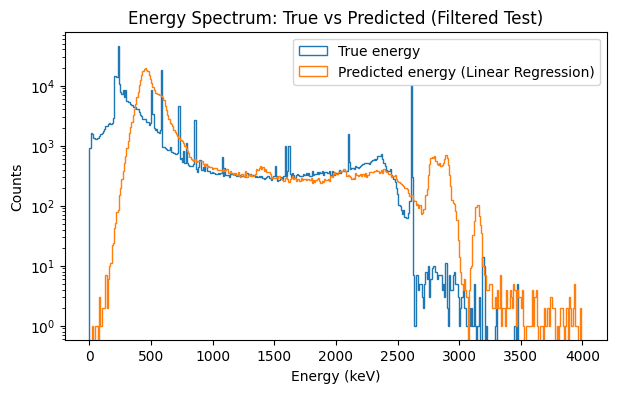

In [65]:
bins = np.linspace(0, 4000, 400)

plt.figure(figsize=(7,4))
plt.hist(y_test, bins=bins, histtype="step", log=True, label="True energy")
plt.hist(y_pred_baseline, bins=bins, histtype="step", log=True, label="Predicted energy (Linear Regression)")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.legend()
plt.title("Energy Spectrum: True vs Predicted (Filtered Test)")
plt.show()

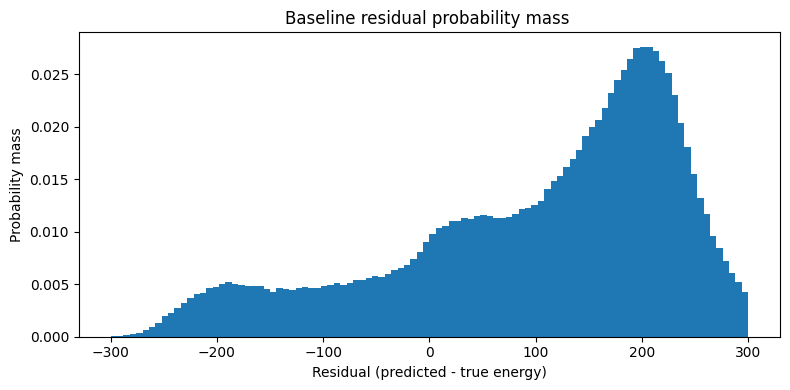

Mass within ±5: 0.0151
Mass within ±10: 0.0297
Mass within ±20: 0.0584
Mass within ±50: 0.1422
Mass within ±100: 0.2775


In [66]:
# Residuals (prediction error)
residuals = y_pred_baseline - y_test.to_numpy()

# Probability mass histogram with fixed range
bins = 100
hist_range = (-300, 300)

counts, bin_edges = np.histogram(
    residuals,
    bins=bins,
    range=hist_range
)

pmf = counts / counts.sum()  # probability mass per bin
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

plt.figure(figsize=(8, 4))
plt.bar(bin_centers, pmf, width=bin_width, align="center")
plt.xlabel("Residual (predicted - true energy)")
plt.ylabel("Probability mass")
plt.title("Baseline residual probability mass ")
plt.tight_layout()
plt.show()

# Cumulative probability mass within error bands
for eps in [5, 10, 20, 50, 100]:
    mass_within = np.mean(np.abs(residuals) <= eps)
    print(f"Mass within ±{eps}: {mass_within:.4f}")


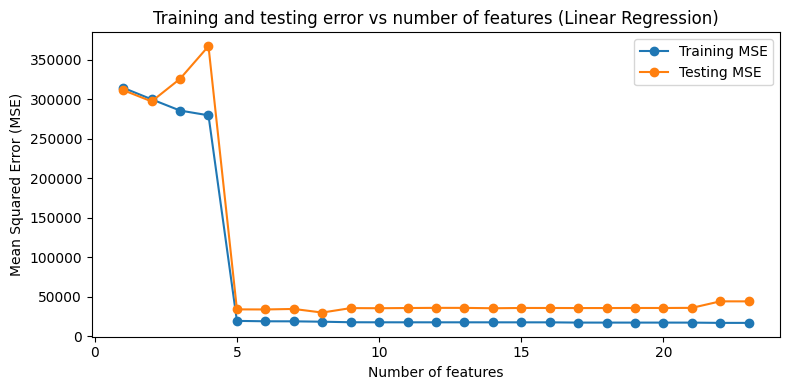

Best k (min test MSE): 8
Best test MSE: 30152.691078756656
Top features used: ['tp0', 'ED', 'HWP', 'PPR', 'total_power', 'time_to_main_peak', 'tdrift99', 'peak_count']


In [67]:
# 1) Rank features by absolute correlation with y_train
corrs = {}
y_train_arr = y_train.to_numpy()

for c in feature_cols:
    x = X_train[c].to_numpy()
    # guard against constant features
    if np.std(x) == 0:
        corrs[c] = 0.0
    else:
        corrs[c] = abs(np.corrcoef(x, y_train_arr)[0, 1])

ranked_features = sorted(corrs, key=corrs.get, reverse=True)

# 2) Loop over number of features
train_mse_list = []
test_mse_list = []
k_list = list(range(1, len(ranked_features) + 1))

for k in k_list:
    feats_k = ranked_features[:k]
    
    pipe_k = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])
    
    pipe_k.fit(X_train[feats_k], y_train)
    
    y_pred_train_k = pipe_k.predict(X_train[feats_k])
    y_pred_test_k = pipe_k.predict(X_test[feats_k])
    
    train_mse_list.append(mean_squared_error(y_train, y_pred_train_k))
    test_mse_list.append(mean_squared_error(y_test, y_pred_test_k))

# 3) Plot
plt.figure(figsize=(8, 4))
plt.plot(k_list, train_mse_list, marker="o", label="Training MSE")
plt.plot(k_list, test_mse_list, marker="o", label="Testing MSE")
plt.xlabel("Number of features")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training and testing error vs number of features (Linear Regression)")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print best k on test
best_k = k_list[int(np.argmin(test_mse_list))]
print("Best k (min test MSE):", best_k)
print("Best test MSE:", min(test_mse_list))
print("Top features used:", ranked_features[:best_k])


In [68]:
coefs = pipe.named_steps["lr"].coef_
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coefs
}).assign(abs_coef=lambda df: np.abs(df["coef"])) \
  .sort_values("abs_coef", ascending=False)


In [69]:
coef_df

,feature,coef,abs_coef
10,total_power,570.192633,570.192633
4,PPR,-78.763528,78.763528
0,tp0,73.993027,73.993027
12,time_to_peak,67.548451,67.548451
14,tdrift99,-63.408623,63.408623
5,SCA,53.978006,53.978006
9,current_kurtosis,48.002997,48.002997
6,current_skewness,-44.854011,44.854011
16,peak_count,-39.347854,39.347854
1,ED,34.050690,34.050690


## Gradient Boosted Trees (XGBoost)

In [74]:
xgb_reg = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

In [75]:
X_train.max().sort_values(ascending=False).head(10)


LQ80                       1.646664e+130
GradAreaRatio               7.968905e+12
total_power                 5.260858e+10
spectral_centroid_power     1.637442e+04
HWP                         3.799000e+03
ED                          3.790000e+03
tdrift99                    2.919000e+03
time_to_peak                2.919000e+03
tp0                         1.352000e+03
time_to_main_peak           4.960000e+02
dtype: float64

In [76]:
xgb_reg.fit(X_train, y_train)

XGBoostError: [22:12:47] C:\actions-runner\_work\xgboost\xgboost\src\data\gradient_index.h:100: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`

In [ ]:
y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [ ]:
print("XGBRegressor Test MSE:", mse)
print("XGBRegressor Test RMSE:", rmse)

XGBRegressor Test MSE: 1474.6597443658225
XGBRegressor Test RMSE: 38.40129873280098


In [ ]:
y_pred_train = xgb_reg.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Gap (test - train):", test_mse - train_mse)


Train MSE: 1090.0599680547566
Test MSE: 1474.6597443658225
Gap (test - train): 384.59977631106585


In [ ]:
# ---------------------------
# Working 5-fold CV for XGBoost (MSE + RMSE)
# ---------------------------
# Assumes you already have: X_train, y_train

# Scorers (sklearn expects "higher is better", so we return NEGATIVE errors)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

rmse_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

scoring = {
    "neg_mse": mse_scorer,
    "neg_rmse": rmse_scorer
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    xgb_reg,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"   # if anything breaks, you will see the actual error
)

# Convert back to positive errors (because we used negative scorers)
train_mse = -cv_results["train_neg_mse"]
val_mse = -cv_results["test_neg_mse"]
train_rmse = -cv_results["train_neg_rmse"]
val_rmse = -cv_results["test_neg_rmse"]

print("5-Fold CV Results (XGBoost)")
print(f"Train MSE: mean={train_mse.mean():.3f}, std={train_mse.std():.3f}")
print(f"Valid MSE: mean={val_mse.mean():.3f}, std={val_mse.std():.3f}")
print(f"Train RMSE: mean={train_rmse.mean():.3f}, std={train_rmse.std():.3f}")
print(f"Valid RMSE: mean={val_rmse.mean():.3f}, std={val_rmse.std():.3f}")

gaps = val_mse - train_mse
print("\nFold-by-fold MSE gap (valid - train):", np.round(gaps, 3))
print("Avg gap:", gaps.mean())

5-Fold CV Results (XGBoost)
Train MSE: mean=1049.913, std=12.777
Valid MSE: mean=1441.158, std=32.302
Train RMSE: mean=-32.402, std=0.197
Valid RMSE: mean=-37.960, std=0.426

Fold-by-fold MSE gap (valid - train): [404.62  370.236 444.586 392.329 344.458]
Avg gap: 391.2457482328806


### Hyperparameter Tuning

In [ ]:
# SCORING
scoring = {
    "neg_mse": "neg_mean_squared_error",           # Standard MSE (Negative)
    "neg_rmse": "neg_root_mean_squared_error",     # Standard RMSE (Negative) - BEST FOR PHYSICS
    "r2": "r2"                                     # Goodness of fit (1.0 is perfect)
}

# DEFINE THE PARAMETER GRID
param_grid = {
    # Complexity: How deep and wide the trees are
    'n_estimators': [400, 600, 800],
    'max_depth': [4, 6, 8, 10],       # 6 is standard, 10 catches fine details
    'learning_rate': [0.01, 0.05, 0.1],

    # Robustness: Randomly sampling data to prevent overfitting
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],

    # Regularization: Critical for Energy regression to smooth predictions
    'reg_alpha': [0.0, 0.1, 1.0],     # L1 Regularization (Lasso)
    'reg_lambda': [1.0, 5.0, 10.0]    # L2 Regularization (Ridge)
}

# CONFIGURE THE SEARCH
# K-Fold is better for regression than StratifiedKFold
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scoring,
    refit='neg_rmse',     # <--- OPTIMIZE FOR RMSE (Resolution)
    cv=cv_strategy,
    verbose=1,
    n_jobs=4,             # Parallelize here
    random_state=42
)

print("Tuning XGBoost Regressor for Energy...")
search.fit(X_train, y_train)

Tuning XGBoost Regressor for Energy...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None...
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [4, 6, 8, 10],
                                        'n_estimators': [400, 600, 800],
                                        'reg_alpha': [0.0, 0.1, 1.0],
                                        'reg_lambda': [1.0, 5.0, 10.0],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, refit='neg_rmse',
                   scoring={'neg_mse': 'neg_mean_squared_error',
                            'neg_rmse': 'neg_root_mean_squared_error',
                            'r2': 'r2'},
                   verbose=1)

In [ ]:
# ==========================================
# 4. RESULTS TABLE
# ==========================================
print("\n>>> TOP 5 MODELS (Sorted by RMSE) <<<")

results = pd.DataFrame(search.cv_results_)

# Select and Rename Columns for Clarity
cols = [
    'rank_test_neg_rmse',
    'mean_test_neg_rmse',  # Main Metric
    'mean_test_neg_mse',
    'mean_test_r2',        # Secondary Metric
    'params'
]

# Sort by RMSE (Highest negative value is best, e.g. -5 is better than -10)
top_models = results.sort_values(by='mean_test_neg_rmse', ascending=False)[cols]

# Clean up the output to make it readable (Remove the negative sign for display)
top_models['RMSE (keV)'] = -top_models['mean_test_neg_rmse']
top_models['MSE'] = -top_models['mean_test_neg_mse']

# Display
model_xgb_ref = top_models[['rank_test_neg_rmse', 'RMSE (keV)', 'MSE', 'mean_test_r2', 'params']]
model_xgb_ref.head()


>>> TOP 5 MODELS (Sorted by RMSE) <<<


,rank_test_neg_rmse,RMSE (keV),MSE,mean_test_r2,params
19,1,33.286228,1108.255565,0.997534,"{'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alp..."
16,2,33.331592,1111.250164,0.997527,"{'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alp..."
15,3,33.335089,1111.541564,0.997527,"{'subsample': 0.7, 'reg_lambda': 5.0, 'reg_alp..."
0,4,33.605823,1129.827084,0.997486,"{'subsample': 0.9, 'reg_lambda': 5.0, 'reg_alp..."
17,5,34.688832,1203.497475,0.997322,"{'subsample': 0.7, 'reg_lambda': 5.0, 'reg_alp..."


In [ ]:
# ==========================================
# 4. EVALUATE THE BEST MODEL
# ==========================================
best_reg = search.best_estimator_
print(f"\nBest Params: {search.best_params_}")

# Predict on Test Set
y_pred_xgb = best_reg.predict(X_test)

# Calculate Physics Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print("-" * 40)
print(f"Energy Resolution (RMSE): {rmse:.4f} (Lower is better)")
print(f"Mean Absolute Error:      {mae:.4f}")
print(f"R2 Score:                 {r2:.4f} (1.0 is perfect)")
print("-" * 40)


Best Params: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
----------------------------------------
Energy Resolution (RMSE): 33.0110 (Lower is better)
Mean Absolute Error:      7.4256
R2 Score:                 0.9976 (1.0 is perfect)
----------------------------------------


In [ ]:
# XGBoost with best hyperparameters founds

# ==========================================
# 5. TRAIN FINAL XGBOOST MODEL (BEST PARAMS)
# ==========================================

best_params = search.best_params_

final_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42
)

# Fit on full training data
final_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# ==========================================
# 6. EVALUATE FINAL MODEL
# ==========================================

y_pred_final = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_final)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_final)
r2 = r2_score(y_test, y_pred_final)

print("-" * 40)
print("Final XGBoost Model Performance")
print(f"MSE:                      {mse:.4f}")
print(f"RMSE (Energy Resolution): {rmse:.4f}")
print(f"MAE:                      {mae:.4f}")
print(f"R2 Score:                 {r2:.4f}")
print("-" * 40)

----------------------------------------
Final XGBoost Model Performance
MSE:                      1089.7294
RMSE (Energy Resolution): 33.0110
MAE:                      7.4256
R2 Score:                 0.9976
----------------------------------------


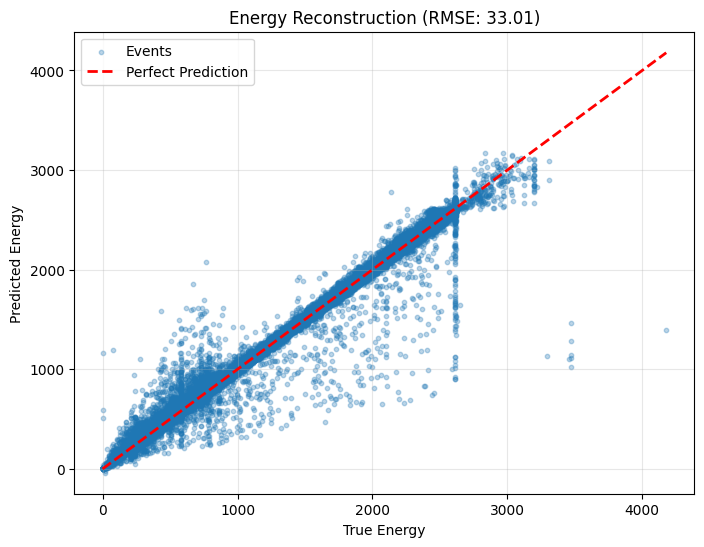

In [ ]:
# VISUALIZATION: PREDICTED vs ACTUAL
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_final, alpha=0.3, s=10, label='Events')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel("True Energy")
plt.ylabel("Predicted Energy")
plt.title(f"Energy Reconstruction (RMSE: {rmse:.2f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

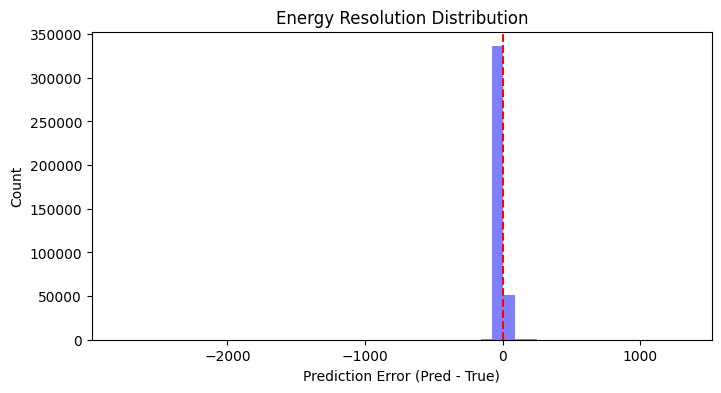

In [ ]:
# RESIDUAL PLOT (Bias Check)
# Checks if you are consistently over/under-predicting
residuals = y_pred_final - y_test
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50, histtype='stepfilled', alpha=0.5, color='blue')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Prediction Error (Pred - True)")
plt.ylabel("Count")
plt.title("Energy Resolution Distribution")
plt.show()

<Figure size 1000x800 with 0 Axes>

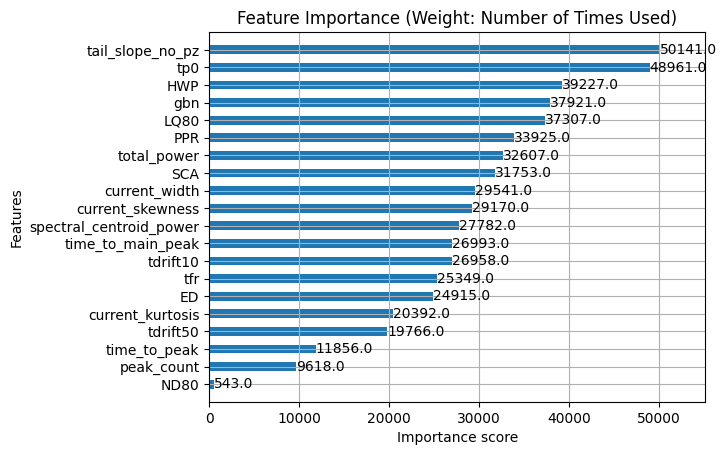

In [ ]:
feature_names = X_train.columns.tolist()

plt.figure(figsize=(10, 8))
xgb.plot_importance(final_model, height=0.5, importance_type='weight')
plt.title("Feature Importance (Weight: Number of Times Used)")
plt.show()

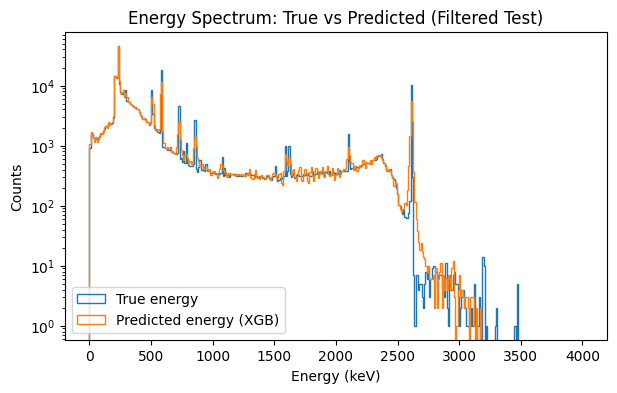

In [ ]:
bins = np.linspace(0, 4000, 400)

plt.figure(figsize=(7,4))
plt.hist(y_test, bins=bins, histtype="step", log=True, label="True energy")
plt.hist(y_pred_final, bins=bins, histtype="step", log=True, label="Predicted energy (XGB)")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.legend()
plt.title("Energy Spectrum: True vs Predicted (Filtered Test)")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Compute MSE
mse_lr = mean_squared_error(y_test, y_pred_baseline)      # Linear Regression
mse_xgb_pre = mean_squared_error(y_test, y_pred)          # XGBoost before tuning
mse_xgb_post = mean_squared_error(y_test, y_pred_final)   # XGBoost after tuning

# Compute RMSE
rmse_lr = np.sqrt(mse_lr)
rmse_xgb_pre = np.sqrt(mse_xgb_pre)
rmse_xgb_post = np.sqrt(mse_xgb_post)

# Create comparison table
mse_table = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "XGBoost (Before Tuning)",
        "XGBoost (After Tuning)"
    ],
    "MSE": [mse_lr, mse_xgb_pre, mse_xgb_post],
    "RMSE": [rmse_lr, rmse_xgb_pre, rmse_xgb_post]
}).sort_values("MSE")

print(mse_table.to_string(index=False))


                  Model         MSE      RMSE
 XGBoost (After Tuning) 1089.729395 33.011050
XGBoost (Before Tuning) 1474.659744 38.401299
      Linear Regression 5973.138813 77.286084
